**Question:** Can a neural network learn the function $f(x,y) = x^2 + y^2$ by imitating the book's implementation of a neural network build on pytorch?   (See pages 395-407.)


## Building a multilayer perceptron for classifying flowers in the Iris dataset

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 

iris = load_iris()
X = iris['data']
y = iris['target']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [7]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x
    
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
 
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

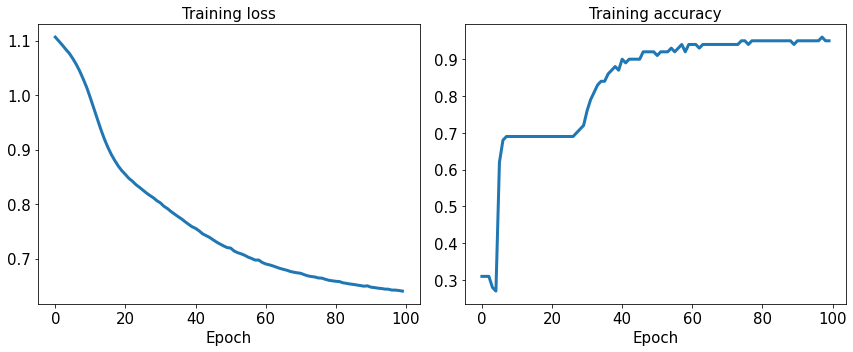

In [9]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

#plt.savefig('figures/12_09.pdf')
 
plt.show()

### Evaluating the trained model on the test dataset

In [16]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')


Test Acc.: 0.9800


### Saving and reloading the trained model

In [17]:
path = 'iris_classifier.pt'
torch.save(model, path)

In [18]:
model_new = torch.load(path)
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [19]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [20]:
path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [21]:
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))


<All keys matched successfully>

## Choosing activation functions for multilayer neural networks ##



### Logistic function recap

In [22]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print(f'P(y=1|x) = {logistic_activation(X, w):.3f}') 

P(y=1|x) = 0.888


In [23]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas) 

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [24]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label:', y_class) 

Predicted class label: 0


### Estimating class probabilities in multiclass classification via the softmax function

In [25]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

In [26]:
torch.softmax(torch.from_numpy(Z), dim=0)

tensor([0.4467, 0.1611, 0.3922], dtype=torch.float64)

### Broadening the output spectrum using a hyperbolic tangent

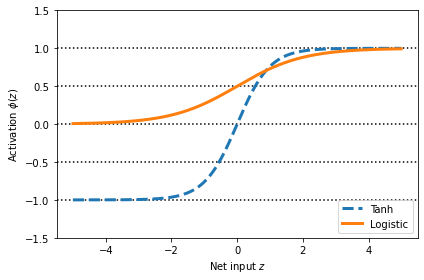

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()

#plt.savefig('figures/12_10.pdf')
plt.show()

In [28]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [29]:
torch.tanh(torch.from_numpy(z))
 

tensor([-0.9999, -0.9999, -0.9999,  ...,  0.9999,  0.9999,  0.9999],
       dtype=torch.float64)

In [30]:
from scipy.special import expit

expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [31]:
torch.sigmoid(torch.from_numpy(z))

tensor([0.0067, 0.0067, 0.0068,  ..., 0.9932, 0.9932, 0.9933],
       dtype=torch.float64)

### Rectified linear unit activation

In [32]:
torch.relu(torch.from_numpy(z))

tensor([0.0000, 0.0000, 0.0000,  ..., 4.9850, 4.9900, 4.9950],
       dtype=torch.float64)

## Generating the data and preparing it for loading ##

In [10]:
tempX = np.random.uniform(-1,1,2000)
tempY = np.random.uniform(-1,1,2000)

In [11]:
myX = np.array([tempX, tempY]).T

In [12]:
myX[:5]

array([[ 0.63888453,  0.5134381 ],
       [ 0.54218392, -0.0463582 ],
       [ 0.56546269,  0.4160673 ],
       [ 0.74693125,  0.69202881],
       [-0.69187552, -0.22244369]])

In [13]:
def myfunc(X):
    
    return X[:,0]**2 + X[:,1]**2

In [14]:
myy = myfunc(myX)

In [15]:
myy[:5]

array([0.67179212, 0.29611248, 0.49286005, 1.03681017, 0.52817293])

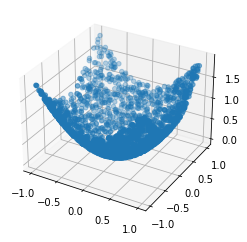

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(myX[:,0], myX[:,1], myy)
plt.show()

In [17]:
myXtensor = torch.from_numpy(myX)

In [18]:
myXtensor.get_device()

-1

In [19]:
myXtensor[:5]

tensor([[ 0.6389,  0.5134],
        [ 0.5422, -0.0464],
        [ 0.5655,  0.4161],
        [ 0.7469,  0.6920],
        [-0.6919, -0.2224]], dtype=torch.float64)

In [20]:
# myXtensor = myXtensor.to(torch.float32)

In [21]:
myXtensor[:5]

tensor([[ 0.6389,  0.5134],
        [ 0.5422, -0.0464],
        [ 0.5655,  0.4161],
        [ 0.7469,  0.6920],
        [-0.6919, -0.2224]], dtype=torch.float64)

In [22]:
myXtensor.shape

torch.Size([2000, 2])

In [23]:
myytensor = torch.from_numpy(myy)
# myytensor = myytensor.to(torch.float32)

In [24]:
myytensor[:5]

tensor([0.6718, 0.2961, 0.4929, 1.0368, 0.5282], dtype=torch.float64)

In [25]:
myytensor.shape

torch.Size([2000])

In [26]:
myytensor.dtype

torch.float64

In [27]:
train_ds = torch.utils.data.TensorDataset(myXtensor, myytensor)

In [28]:
batch_size = 2

In [29]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True)

## Modifying the Model class ##

What do we have to do to the textbook's 'Model' (inherited from pytorch's "nn.Module" class) on pages 395-407 to make it work for learning the function $f(x,y) = x^2 + y^2$?  Some things to consider:

+ Use MSELoss (because it's continuous, not categorical, data)
+ Use ReLU instead of Sigmoid (see p. 405)
+ Use Adam instead of SGD
+ Increase the number of layers and their sizes

Also, I added a 'print' statement at the end of each epoch to show me what the loss function was for the latest batch.

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        return x
    
input_size = 2
hidden_size = 16
output_size = 1
 
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001

loss_fn = nn.MSELoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## An Attempt At Training a Revised Model ##

We want the loss function to (more-or-less) continually decrease.  That doesn't seem to be happening. Sigh.

In [35]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch.float())
        loss = loss_fn(pred, y_batch.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print('Epoch ', epoch, ' with loss ', loss.item())
#       loss_hist[epoch] += loss.item()*y_batch.size(0)
#        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
#        accuracy_hist[epoch] += is_correct.sum()
        
#    loss_hist[epoch] /= len(train_dl.dataset)
#    accuracy_hist[epoch] /= len(train_dl.dataset)

Epoch  0  with loss  0.13112948834896088
Epoch  1  with loss  0.13169074058532715
Epoch  2  with loss  0.021666256710886955
Epoch  3  with loss  0.08764585852622986
Epoch  4  with loss  0.017130084335803986
Epoch  5  with loss  0.0723077654838562
Epoch  6  with loss  0.014540600590407848
Epoch  7  with loss  0.08606275171041489
Epoch  8  with loss  0.12630820274353027
Epoch  9  with loss  0.13486263155937195
Epoch  10  with loss  0.018419839441776276
Epoch  11  with loss  0.3339717388153076
Epoch  12  with loss  0.07888242602348328
Epoch  13  with loss  0.01466606929898262
Epoch  14  with loss  0.04055489972233772
Epoch  15  with loss  0.20079202950000763
Epoch  16  with loss  0.10241777449846268
Epoch  17  with loss  0.0057434942573308945
Epoch  18  with loss  0.1782321333885193
Epoch  19  with loss  0.029155248776078224
Epoch  20  with loss  0.0995849147439003
Epoch  21  with loss  0.3295959532260895
Epoch  22  with loss  0.15069924294948578
Epoch  23  with loss  0.27335572242736816
